In [1]:
import nltk
import numpy as np
import os, glob
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
sw = stopwords.words('english')
from string import punctuation
from collections import Counter
from collections import defaultdict
%matplotlib inline
from spacy import displacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from bs4 import BeautifulSoup
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
from spacy.matcher import Matcher
from nltk.book import *
from string import punctuation

### Executive Summary
I chose to analyze text scripts from two half hour, workplace sitcoms that were both shot in the mockumentary style, *The Office* and *Parks and Recreation*. I found and downloaded the scripts from Kagle, *The Office* scripts were in a single CSV, and the *Parks and Recreation* scripts were in 126 individual CSVs that I combined into single file. I then cleaned both files to only include the lines that were spoken.

I then used spaCy to parse the scripts and find the most common names spoken, as well as the most common, verbs, nouns and SVOs, top words as well as some descriptive statistics about the scripts (those can be seen in the first table).

I was surprised to discover that shows had quite a bit in common in terms of the words spoken, 42 of the top 50 words were the same, and 10 of the top 15 SVOs were the same. I was also surprised to learn that some main characters don’t have their names spoken as many times I would have thought.I think it is interesting that *Parks and Recreation* has a higher lexical diversity given that it has less tokens.

In [156]:
corpus_stats

,Show,Total_Tokens,Unique_Tokens,Lexical_Diversity,Seasons,Episodes
0,The Office,182291,14186,0.0778,9,201
1,Parks & Recreation,122998,12460,0.1013,7,126


### Introduction
I was inspired to do this after listening to an episode of the *Office Ladies* Podcast (an Office rewatch podcast) where they discussed how someone analyzed the transcripts of their podcast and found the most common word they said was lady. I was also curious how spaCy would handle the names in *Parks and Recreation* as it used some very odd names for people and places. 


### Data

#### *Parks & Recreation* Scripts
https://www.kaggle.com/heheheluke/parks-and-recreation-scripts

Each episode was in its own CSV file, so I combined all 126 files into one CSV.

In [2]:
path = "\\Users\heath\\OneDrive - The University of Montana\\text_mining\\Acquire_Analyze\\tv_shows\\parks_scripts"

In [3]:
all_files = glob.glob(os.path.join(path, "s*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged   = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv( "parks_rec_merged.csv")

In [ ]:
# Turn CSV into a Pandas DF
parks = pd.read_csv("parks_rec_merged.csv")
#parks.head(5)

In [ ]:
# Remove columns
parks = parks.drop(columns=['Unnamed: 0', 'Character'])
#parks.head(5)

In [ ]:
parks.to_csv('parks_new.csv', sep=',',  index=False, encoding='utf-8')

#### Read in The Office
https://www.kaggle.com/lillitarhea/the-office-script-lines

In [4]:
office = pd.read_csv("The_Office_lines.csv")
#office.head(5)

In [5]:
# Remove columns
office = office.drop(columns=['id', 'season', 'episode', 'scene', 'speaker', 'deleted'])
#office.head(5)

In [6]:
office.to_csv('office_new.csv', sep=',',  index=False, encoding='utf-8')

#### Bring in files

In [10]:
parks = open("parks_new.csv",'r', encoding='utf-8').read()
office = open("office_new.csv",'r', encoding='utf-8').read()

In [11]:
# Change CSV to TXT

# reading csv file
parks = open("parks_new.csv", "r")

# joining with space content of text
parks = ' '.join([i for i in parks])

# replacing ',' by space
parks = parks.replace(",", " ")

#displaying result
#print(parks)

In [ ]:
#len(parks) #2412428

In [12]:
# Change CSV to TXT

# reading csv file
office = open("office_new.csv", "r")

# joining with space content of text
office = ' '.join([i for i in office])

# replacing ',' by space
office = office.replace(",", " ")

#displaying result
#print(office)

In [97]:
#len(office) #3748212

#### NLP spaCy

In [17]:
nlp = spacy.load('en_core_web_sm') 
nlp.max_length = 4900000 #or any large value, as long as you don't run out of RAnlp = spacy.load('en_core_web_sm')

In [18]:
office = nlp(office)

In [32]:
parks = nlp(parks)

### Results - *The Office*

In [157]:
print("There were {} words parsed in {} sentences from The Office Scripts before cleaning.".format(len(office),len(list(office.sents))))

There were 1028443 words parsed in 108576 sentences from The Office Scripts before cleaning.


In [158]:
f'The Office has {office_results["tokens"]} total tokens, of which {office_results["unique_tokens"]} are unique. There is a lexical diversity of {office_results["lexical_diversity"]} after cleaning.'

'The Office has 182291 total tokens, of which 14186 are unique. There is a lexical diversity of 0.07782062745829471 after cleaning.'

In [161]:
f'The top 25 words and counts in The Office are {office_results["top_25"]} after cleaning.'

"The top 25 words and counts in The Office are [('like', 2917), ('know', 2772), ('get', 2526), ('think', 2087), ('going', 1814), ('want', 1700), ('would', 1610), ('really', 1530), ('gonna', 1525), ('one', 1524), ('go', 1448), ('got', 1383), ('come', 1290), ('good', 1179), ('could', 1092), ('see', 1079), ('need', 1078), ('take', 976), ('right', 944), ('thank', 934), ('little', 934), ('make', 929), ('back', 902), ('tell', 874), ('say', 871)] after cleaning."

In [21]:
office_people = [ent.text for ent in office.ents if ent.label_ == "PERSON"]

In [159]:
print("There are {} possible references to people in the The Office Scripts.".format(len(office_people)))

There are 11791 possible references to people in the The Office Scripts.


In [23]:
people_freq_office = Counter(office_people)

In [184]:
# Top 20 most common names/people
top_people_office = people_freq_office.most_common(20)

In [186]:
office_names = pd.DataFrame(top_people_office, columns=['names', 'count'])
office_names

,names,count
0,Michael,1771
1,Jim,844
2,Andy,536
3,Dwight,517
4,Phyllis,355
5,Erin,307
6,Kevin,306
7,Oscar,268
8,Ryan,250
9,Darryl,210


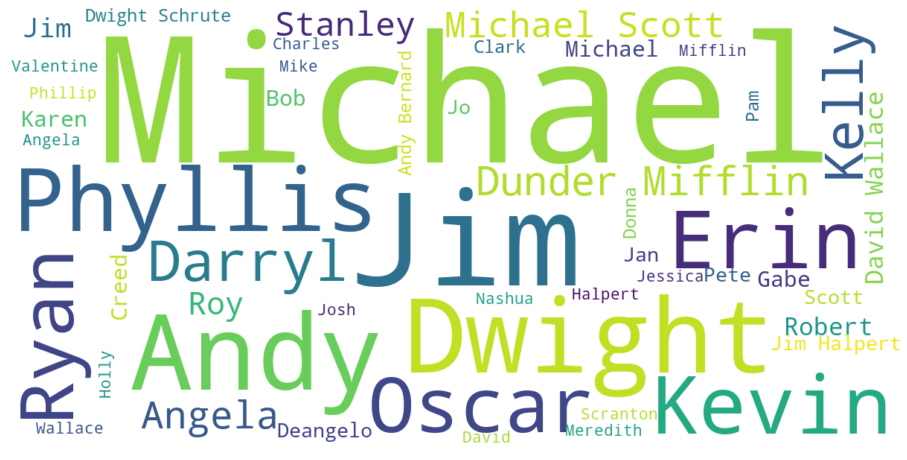

In [182]:
office_people_dict = OrderedDict(people_freq_office.most_common(50))

wc = WordCloud(background_color="white", scale=3)
wc.generate_from_frequencies(office_people_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Not too surprising that Michael, Andy, Jim and Dwight are some of the top names, as they are main characters, I am surprised that Phyllis, Erin and Kevin are in the top. I was really surprised to see that Pam was not more common as she was a main character and was in the series the entire time, where Erin was introduced into the show in the fifth season and they both played the same receptionist role.

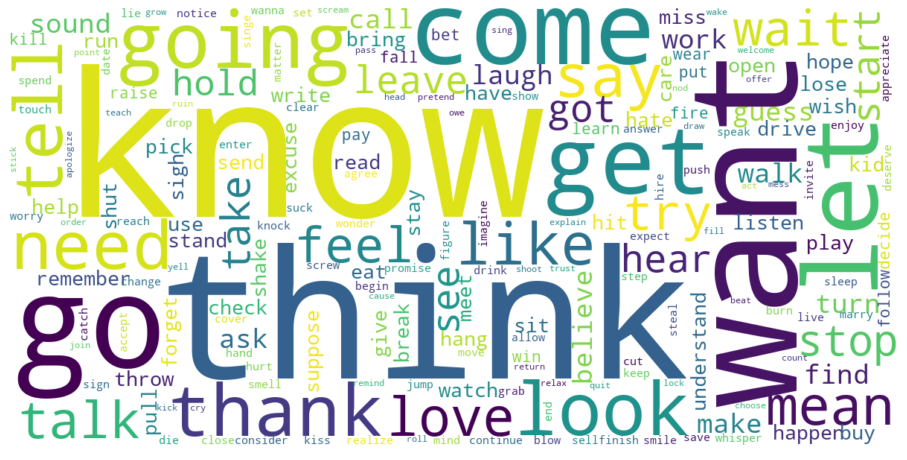

In [28]:
verbs = [token.lemma_ for token in office if token.pos_ == "VERB" and token.dep_ == "ROOT" and token.is_stop == False]
verbs_freq = Counter(verbs)
verbs_dict = OrderedDict(verbs_freq.most_common())

wc = WordCloud(background_color="white", scale=3, stopwords=STOPWORDS)
wc.generate_from_frequencies(verbs_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Think, know and want, are the most common verb, probably not too surprising given they are in the top 25 words. I would imagine these are probably some if the most common verbs spoken, especially in a workplace, "I want you to make me a copy", "I think the logo should be bigger", "I know the client said".

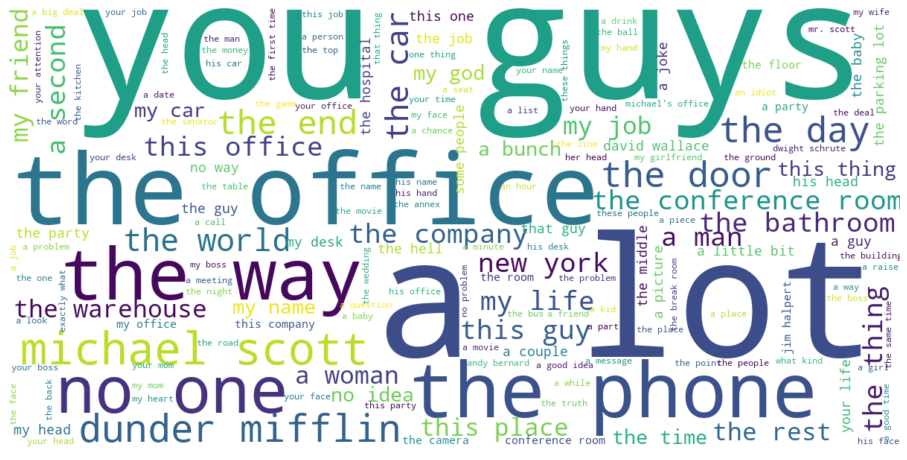

In [29]:
noun_chunks = [chunk.text.lower() for chunk in office.noun_chunks if len(chunk.text.split()) > 1]
noun_chunks_freq = Counter(noun_chunks)
noun_chunks_dict = OrderedDict(noun_chunks_freq.most_common())

wc = WordCloud(background_color="white", scale=3)
wc.generate_from_frequencies(noun_chunks_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Most of the top nouns seem to be pretty generic a lot, you guys, not too surprising that the office and the phone are top noun, since it is about an office.

In [30]:
def get_SVOs(text):
    matcher = Matcher(nlp.vocab)

    pattern = [{'DEP': 'nsubj'},
               {'IS_ALPHA': True, 'OP': '*'},
               {'DEP': 'ROOT'},
               {'IS_ALPHA': True, 'OP': '*'},
               {'DEP': 'dobj'}]

    matcher.add("SVOs", [pattern])
    matches = matcher(text)
    result = []
    tail = 0

    for match_id, start, end in matches:
        if start > tail: # we haven't seen these words yet
            span = text[start:end]
            tail = end # let's not look at this phrase after this
            svo = [token for token in span if token.dep_ in ['nsubj','ROOT','dobj']]
            result.append(svo[:3])

    return result

In [183]:
svos = get_SVOs(office)
svos_text_list = [" ".join([token.text.lower() for token in svo]) for svo in svos]
svos_text_freq = Counter(svos_text_list)
svos_text_dict = OrderedDict(svos_text_freq.most_common())

office_svo = svos_text_freq.most_common(15)
#office_svo

The top SVOs seem to align with the top verbs, want, think and know.

In [194]:
office_svo

,Office SVO,SVO Count Office
0,that 's what,142
1,i want you,104
2,you know what,96
3,i think i,86
4,i think you,57
5,i think we,55
6,i love you,54
7,i got it,50
8,i need you,46
9,i love it,46


### Results - *Parks and Recreation*

In [163]:
print("There were {} words parsed in {} sentences from the Parks and Recreation Scripts.".format(len(parks),len(list(office.sents))))

There were 678717 words parsed in 108576 sentences from the Parks and Recreation Scripts.


In [164]:
f'Parks and Recreation has {parks_results["tokens"]} total tokens, of which {parks_results["unique_tokens"]} are unique. There is a lexical diversity of {parks_results["lexical_diversity"]}.'

'Parks and Recreation has 122998 total tokens, of which 12460 are unique. There is a lexical diversity of 0.10130246020260492.'

In [165]:
f'The top 25 words and counts in Parks and Recreation are {parks_results["top_25"]}.'

"The top 25 words and counts in Parks and Recreation are [('like', 1902), ('get', 1589), ('know', 1420), ('gonna', 1390), ('think', 1140), ('want', 1079), ('one', 1003), ('got', 1002), ('would', 987), ('go', 981), ('going', 963), ('really', 941), ('need', 876), ('good', 714), ('love', 667), ('could', 656), ('take', 655), ('make', 628), ('come', 627), ('right', 599), ('thank', 575), ('see', 573), ('say', 562), ('little', 560), ('people', 534)]."

In [166]:
parks_people = [ent.text for ent in parks.ents if ent.label_ == "PERSON"]

In [167]:
print("Found {} possible references to people in the Parks and Recreation Scripts.".format(len(parks_people)))

Found 6317 possible references to people in the Parks and Recreation Scripts.


In [79]:
people_parks_freq = Counter(parks_people)

In [196]:
top_people_parks = people_parks_freq.most_common(20)

In [197]:
parks_names = pd.DataFrame(top_people_parks, columns=['names', 'count'])
parks_names

,names,count
0,Leslie,829
1,Ron,397
2,Tom,362
3,Ben,287
4,Leslie Knope,250
5,Chris,240
6,Andy,161
7,Knope,115
8,Ron Swanson,104
9,Tammy,90


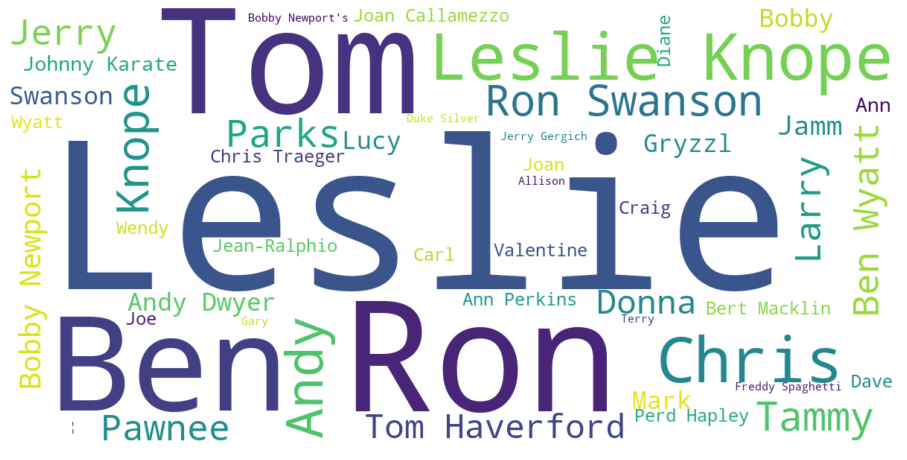

In [95]:
parks_people_dict = OrderedDict(people_parks_freq.most_common(50))

wc = WordCloud(background_color="white", scale=3)
wc.generate_from_frequencies(parks_people_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Not surprising that the name Leslie is the most frequent name as she is a main character, as are Ron and Tom and Ben. I find it interesting that the use of those characters first and last names are pretty common too. Was surprised that Ann was not more common as I would consider her a main character.

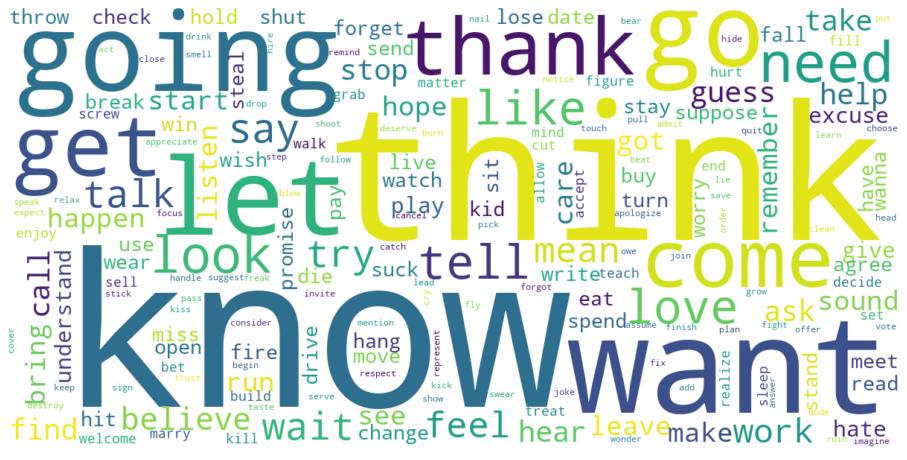

In [51]:
verbs = [token.lemma_ for token in parks if token.pos_ == "VERB" and token.dep_ == "ROOT" and token.is_stop == False]
verbs_freq = Counter(verbs)
verbs_dict = OrderedDict(verbs_freq.most_common())

wc = WordCloud(background_color="white", scale=3, #stopwords=STOPWORDS
              )
wc.generate_from_frequencies(verbs_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Interesting that the top verbs are similar in both with think, know and want as the most common.

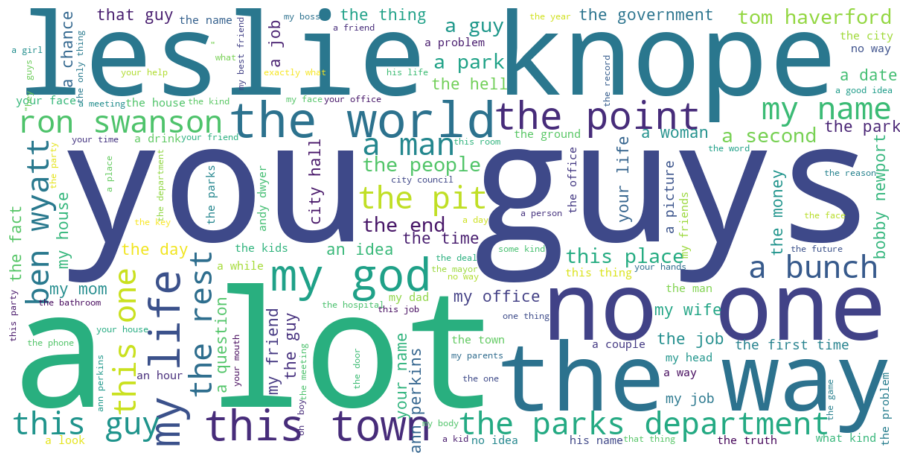

In [48]:
noun_chunks = [chunk.text.lower() for chunk in parks.noun_chunks if len(chunk.text.split()) > 1]
noun_chunks_freq = Counter(noun_chunks)
noun_chunks_dict = OrderedDict(noun_chunks_freq.most_common())

wc = WordCloud(background_color="white", scale=3)
wc.generate_from_frequencies(noun_chunks_dict)
plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Again, the top nouns are similar between the two shows, you guys, a lot, *Parks and Recreation* does have a character as a top noun which wasn't the case in *The Office*.

In [49]:
def get_SVOs(text):
    matcher = Matcher(nlp.vocab)

    pattern = [{'DEP': 'nsubj'},
               {'IS_ALPHA': True, 'OP': '*'},
               {'DEP': 'ROOT'},
               {'IS_ALPHA': True, 'OP': '*'},
               {'DEP': 'dobj'}]

    matcher.add("SVOs", [pattern])
    matches = matcher(text)
    result = []
    tail = 0

    for match_id, start, end in matches:
        if start > tail: # we haven't seen these words yet
            span = text[start:end]
            tail = end # let's not look at this phrase after this
            svo = [token for token in span if token.dep_ in ['nsubj','ROOT','dobj']]
            result.append(svo[:3])

    return result

In [172]:
svos = get_SVOs(parks)
svos_text_list = [" ".join([token.text.lower() for token in svo]) for svo in svos]
svos_text_freq = Counter(svos_text_list)
svos_text_dict = OrderedDict(svos_text_freq.most_common())

parks_svo = svos_text_freq.most_common(15)
#parks_svo

The top SVOs seem to align with the top verbs, want, think and know. Interesting that I love you is the top SVO in *Parks and Recreation*, I wonder which character says it the most.

In [198]:
parks_svo

,Parks SVO,SVO Count Parks
0,i love you,94
1,that 's what,62
2,you know what,57
3,i have idea,51
4,i want you,47
5,i think we,47
6,i think i,43
7,i need you,39
8,you got it,37
9,it 's you,37


Turn SVO Lists into DF

In [201]:
parks_svo = pd.DataFrame(parks_svo, columns=['Parks SVO', 'SVO Count Parks'])
office_svo = pd.DataFrame(office_svo, columns=['Office SVO', 'SVO Count Office'])

In [202]:
same_svo = pd.merge(office_svo, parks_svo, how='inner', left_on='Office SVO', right_on='Parks SVO')

Ten of the top 15 SVOs for both *The Office* and *Parks and Recreation* are the same. Below is a comparison of the ones that match and their counts.

In [203]:
same_svo

,Office SVO,SVO Count Office,Parks SVO,SVO Count Parks
0,that 's what,142,that 's what,62
1,i want you,104,i want you,47
2,you know what,96,you know what,57
3,i think i,86,i think i,43
4,i think you,57,i think you,37
5,i think we,55,i think we,47
6,i love you,54,i love you,94
7,i need you,46,i need you,39
8,i love it,46,i love it,35
9,it 's you,41,it 's you,37


In [204]:
#result = pd.concat([parks_svo, office_svo], axis=1, join='inner')
#display(result)

#### Common Words Comparision

In [173]:
office_df = pd.DataFrame(data = office_results['top_50'], columns=['office_word','office_count'])
parks_df = pd.DataFrame(data = parks_results['top_50'], columns=['parks_word','parks_count'])

In [178]:
top_words = pd.concat([office_df, parks_df], axis=1)
#top_words

In [179]:
same_top_words = pd.merge(office_df, parks_df, how='inner', left_on='office_word', right_on='parks_word')

Curious to see how many of the top 50 words were the same between the top three I compared them. Between *The Office* and *Parks and Recreation* 42 were the same.

In [180]:
same_top_words

,office_word,office_count,parks_word,parks_count
0,like,2917,like,1902
1,know,2772,know,1420
2,get,2526,get,1589
3,think,2087,think,1140
4,going,1814,going,963
5,want,1700,want,1079
6,would,1610,would,987
7,really,1530,really,941
8,gonna,1525,gonna,1390
9,one,1524,one,1003


While working on the write up I thought of some things that might be interesting to analyze further.
- Compare the US and British versions of *The Office*
- Compare how many lines each character had overall and/or in each season
- See if certain characters had more of certain SVOs than others
- Compare to other tv shows, maybe one that is not a comedy or maybe a book of some sort
- Compare episodes/seasons to see if there are differences episode to episode or season to season in terms of common, nouns, verbs, SVOs.

Find stats on the scripts

In [146]:
def get_patterns(text)  :
    """
        This function takes text as an input and returns a dictionary of statistics,
        after cleaning the text. 
    """   
    # We'll make things a big clearer by initializing the 
    # statistics here. These are placeholder values.
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lex_diversity = 0.0
    top_10 = Counter()
     
    # Calculate your statistics here
    total_tokens = len(text)
    unique_tokens = len(set(text))
    #Build a vector of token length
    text_token_len = [len(w) for w in text]
    avg_token_len = np.mean(text_token_len)
    lex_diversity = len(set(text))/len(text)
    text_fd = FreqDist(text)
    top_50 = text_fd.most_common(50)
    top_25 = text_fd.most_common(25)

    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':avg_token_len,
               'lexical_diversity':lex_diversity,
               'top_50':top_50,
               'top_25':top_25
              }        

    return(results)

In [149]:
office_results = get_patterns(office_clean)
parks_results = get_patterns(parks_clean)

In [168]:
#f'The Office has {office_results["tokens"]} total tokens, of which {office_results["unique_tokens"]} are unique. There is a lexical diversity of {office_results["lexical_diversity"]}.'

In [169]:
#f'Parks and Recreation has {office_results["tokens"]} total tokens, of which {office_results["unique_tokens"]} are unique. There is a lexical diversity of {parks_results["lexical_diversity"]}.'

In [170]:
#f'The top 25 words and counts in The Office are {office_results["top_25"]}.'

In [171]:
#f'The top 25 words and counts in Parks and Recreation are {parks_results["top_25"]}.'

In [162]:
# initialize list of lists
data = [['The Office', 182291, 14186, 0.0778, 9, 201], 
        ['Parks & Recreation', 122998, 12460, 0.1013, 7, 126], 
        ]
  
# Create the pandas DataFrame
corpus_stats = pd.DataFrame(data, columns = ['Show', 'Total_Tokens', 'Unique_Tokens', 'Lexical_Diversity', 'Seasons','Episodes'])
  
# print dataframe.
#corpus_stats